In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

In [2]:
!wget -O facades.zip https://github.com/Adamsonbor/CV_Facades/blob/buf/facades.zip?raw=true

--2023-03-27 10:07:52--  https://github.com/Adamsonbor/CV_Facades/blob/buf/facades.zip?raw=true
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Adamsonbor/CV_Facades/raw/buf/facades.zip [following]
--2023-03-27 10:07:52--  https://github.com/Adamsonbor/CV_Facades/raw/buf/facades.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Adamsonbor/CV_Facades/buf/facades.zip [following]
--2023-03-27 10:07:53--  https://raw.githubusercontent.com/Adamsonbor/CV_Facades/buf/facades.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... conn

In [2]:
!rm -rf ./dataset
!mkdir ./dataset
!unzip ./facades.zip -d ./dataset

Archive:  ./facades.zip
  inflating: ./dataset/metadata.csv  
  inflating: ./dataset/testA/1.jpg   
  inflating: ./dataset/testA/10.jpg  
  inflating: ./dataset/testA/100.jpg  
  inflating: ./dataset/testA/101.jpg  
  inflating: ./dataset/testA/102.jpg  
  inflating: ./dataset/testA/103.jpg  
  inflating: ./dataset/testA/104.jpg  
  inflating: ./dataset/testA/105.jpg  
  inflating: ./dataset/testA/106.jpg  
  inflating: ./dataset/testA/11.jpg  
  inflating: ./dataset/testA/12.jpg  
  inflating: ./dataset/testA/13.jpg  
  inflating: ./dataset/testA/14.jpg  
  inflating: ./dataset/testA/15.jpg  
  inflating: ./dataset/testA/16.jpg  
  inflating: ./dataset/testA/17.jpg  
  inflating: ./dataset/testA/18.jpg  
  inflating: ./dataset/testA/19.jpg  
  inflating: ./dataset/testA/2.jpg   
  inflating: ./dataset/testA/20.jpg  
  inflating: ./dataset/testA/21.jpg  
  inflating: ./dataset/testA/22.jpg  
  inflating: ./dataset/testA/23.jpg  
  inflating: ./dataset/testA/24.jpg  
  inflating: ./data

  inflating: ./dataset/trainA/116_A.jpg  
  inflating: ./dataset/trainA/117_A.jpg  
  inflating: ./dataset/trainA/118_A.jpg  
  inflating: ./dataset/trainA/119_A.jpg  
  inflating: ./dataset/trainA/11_A.jpg  
  inflating: ./dataset/trainA/120_A.jpg  
  inflating: ./dataset/trainA/121_A.jpg  
  inflating: ./dataset/trainA/122_A.jpg  
  inflating: ./dataset/trainA/123_A.jpg  
  inflating: ./dataset/trainA/124_A.jpg  
  inflating: ./dataset/trainA/125_A.jpg  
  inflating: ./dataset/trainA/126_A.jpg  
  inflating: ./dataset/trainA/127_A.jpg  
  inflating: ./dataset/trainA/128_A.jpg  
  inflating: ./dataset/trainA/129_A.jpg  
  inflating: ./dataset/trainA/12_A.jpg  
  inflating: ./dataset/trainA/130_A.jpg  
  inflating: ./dataset/trainA/131_A.jpg  
  inflating: ./dataset/trainA/132_A.jpg  
  inflating: ./dataset/trainA/133_A.jpg  
  inflating: ./dataset/trainA/134_A.jpg  
  inflating: ./dataset/trainA/135_A.jpg  
  inflating: ./dataset/trainA/136_A.jpg  
  inflating: ./dataset/trainA/137_A.

  inflating: ./dataset/trainA/324_A.jpg  
  inflating: ./dataset/trainA/325_A.jpg  
  inflating: ./dataset/trainA/326_A.jpg  
  inflating: ./dataset/trainA/327_A.jpg  
  inflating: ./dataset/trainA/328_A.jpg  
  inflating: ./dataset/trainA/329_A.jpg  
  inflating: ./dataset/trainA/32_A.jpg  
  inflating: ./dataset/trainA/330_A.jpg  
  inflating: ./dataset/trainA/331_A.jpg  
  inflating: ./dataset/trainA/332_A.jpg  
  inflating: ./dataset/trainA/333_A.jpg  
  inflating: ./dataset/trainA/334_A.jpg  
  inflating: ./dataset/trainA/335_A.jpg  
  inflating: ./dataset/trainA/336_A.jpg  
  inflating: ./dataset/trainA/337_A.jpg  
  inflating: ./dataset/trainA/338_A.jpg  
  inflating: ./dataset/trainA/339_A.jpg  
  inflating: ./dataset/trainA/33_A.jpg  
  inflating: ./dataset/trainA/340_A.jpg  
  inflating: ./dataset/trainA/341_A.jpg  
  inflating: ./dataset/trainA/342_A.jpg  
  inflating: ./dataset/trainA/343_A.jpg  
  inflating: ./dataset/trainA/344_A.jpg  
  inflating: ./dataset/trainA/345_A.

  inflating: ./dataset/trainB/149_B.jpg  
  inflating: ./dataset/trainB/14_B.jpg  
  inflating: ./dataset/trainB/150_B.jpg  
  inflating: ./dataset/trainB/151_B.jpg  
  inflating: ./dataset/trainB/152_B.jpg  
  inflating: ./dataset/trainB/153_B.jpg  
  inflating: ./dataset/trainB/154_B.jpg  
  inflating: ./dataset/trainB/155_B.jpg  
  inflating: ./dataset/trainB/156_B.jpg  
  inflating: ./dataset/trainB/157_B.jpg  
  inflating: ./dataset/trainB/158_B.jpg  
  inflating: ./dataset/trainB/159_B.jpg  
  inflating: ./dataset/trainB/15_B.jpg  
  inflating: ./dataset/trainB/160_B.jpg  
  inflating: ./dataset/trainB/161_B.jpg  
  inflating: ./dataset/trainB/162_B.jpg  
  inflating: ./dataset/trainB/163_B.jpg  
  inflating: ./dataset/trainB/164_B.jpg  
  inflating: ./dataset/trainB/165_B.jpg  
  inflating: ./dataset/trainB/166_B.jpg  
  inflating: ./dataset/trainB/167_B.jpg  
  inflating: ./dataset/trainB/168_B.jpg  
  inflating: ./dataset/trainB/169_B.jpg  
  inflating: ./dataset/trainB/16_B.j

  inflating: ./dataset/trainB/343_B.jpg  
  inflating: ./dataset/trainB/344_B.jpg  
  inflating: ./dataset/trainB/345_B.jpg  
  inflating: ./dataset/trainB/346_B.jpg  
  inflating: ./dataset/trainB/347_B.jpg  
  inflating: ./dataset/trainB/348_B.jpg  
  inflating: ./dataset/trainB/349_B.jpg  
  inflating: ./dataset/trainB/34_B.jpg  
  inflating: ./dataset/trainB/350_B.jpg  
  inflating: ./dataset/trainB/351_B.jpg  
  inflating: ./dataset/trainB/352_B.jpg  
  inflating: ./dataset/trainB/353_B.jpg  
  inflating: ./dataset/trainB/354_B.jpg  
  inflating: ./dataset/trainB/355_B.jpg  
  inflating: ./dataset/trainB/356_B.jpg  
  inflating: ./dataset/trainB/357_B.jpg  
  inflating: ./dataset/trainB/358_B.jpg  
  inflating: ./dataset/trainB/359_B.jpg  
  inflating: ./dataset/trainB/35_B.jpg  
  inflating: ./dataset/trainB/360_B.jpg  
  inflating: ./dataset/trainB/361_B.jpg  
  inflating: ./dataset/trainB/362_B.jpg  
  inflating: ./dataset/trainB/363_B.jpg  
  inflating: ./dataset/trainB/364_B.

In [3]:
os.listdir("./dataset/")

['trainB', 'trainA', 'testB', 'metadata.csv', 'testA']

In [2]:
len(os.listdir("./dataset/trainA/"))

400

In [3]:
len(os.listdir("./dataset/testA/"))

106

In [4]:
# custom dataset
class MyDataset(Dataset):
    def __init__(self, x_paths, y_paths, transforms=None):
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.low_thresh = np.array([0,120,250])
        self.high_thresh = np.array([15, 128, 255])
        if transforms:
            self.transforms = transforms
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        x = Image.open(self.x_paths[idx])
        y = self.prepare_y(self.y_paths[idx])
        if self.transforms:
            x = self.transforms(x)
        return x, y
    
    def prepare_y(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img1 = cv2.inRange(img, np.array([0,100,240]),\
                                np.array([20, 130, 255]))
        img2 = cv2.inRange(img, np.array([230,230,0]),\
                                np.array([255, 255, 20]))


        contours, _ = cv2.findContours(img1,\
                                       cv2.RETR_EXTERNAL,\
                                       cv2.CHAIN_APPROX_SIMPLE)
        contours2, _ = cv2.findContours(img2,\
                                        cv2.RETR_EXTERNAL,\
                                        cv2.CHAIN_APPROX_SIMPLE)
        for cont in contours:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        for cont in contours2:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        return torch.tensor(img1 / 255, dtype=torch.float)

In [5]:
# Расчет mean и std
def mean_std(path):
    dataset = []
    mean = np.array([0.,0.,0.])
    std = np.array([0.,0.,0.])
    for imgpath in os.listdir(path):
        img = cv2.imread(f"{path}{imgpath}")
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(float) / 255.
        mean += img.mean(axis=(0,1))
        std += img.std(axis=(0,1))
    mean = mean / len(os.listdir(path))
    std = std / len(os.listdir(path))
    return mean, std


In [6]:
    
mean, std = mean_std("./dataset/trainA/")
transforms = T.Compose([
    T.Resize((256, 256)),
    T.ColorJitter(0.4,0.4,0.4),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   
val_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   

val_size = 0.2
paths = os.listdir("./dataset/trainA/")
x_paths = [f"./dataset/trainA/{path}" for path in paths]
y_paths = [f"./dataset/trainB/{path.replace('A', 'B')}" for path in paths]
X_train, X_val, y_train, y_val = train_test_split(x_paths, \
                                                  y_paths, \
                                                  test_size=0.2, \
                                                  shuffle=True)
train_set = MyDataset(X_train, y_train, transforms)
val_set = MyDataset(X_val, y_val, val_transforms)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

In [7]:
X, y = next(iter(train_loader))
X.shape, y.shape, X.type(), y.type()

(torch.Size([8, 3, 256, 256]),
 torch.Size([8, 256, 256]),
 'torch.FloatTensor',
 'torch.FloatTensor')

In [8]:
def show_mask(img: torch.tensor,\
              mask: torch.tensor,\
              pred=None,\
              mean=(0.5,0.5,0.5),\
              std=(0.5,0.5,0.5)):
    img = img.numpy().transpose(1,2,0) * std + mean
    mask = (mask == 0)
    ov = cv2.bitwise_and(img, img, mask=np.array(mask).astype("uint8"))
    if pred is not None:
        pred = (pred > 0.5)
        fig, axs = plt.subplots(ncols=3)
        axs[0].imshow(ov)
        axs[0].set_title("img")
        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("mask")
        axs[2].imshow(pred, cmap="gray")
        axs[2].set_title("pred")
        plt.show()
    else:
        fig, axs = plt.subplots(ncols=2)
        axs[0].imshow(ov)
        axs[0].set_title("img")
        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("mask")
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


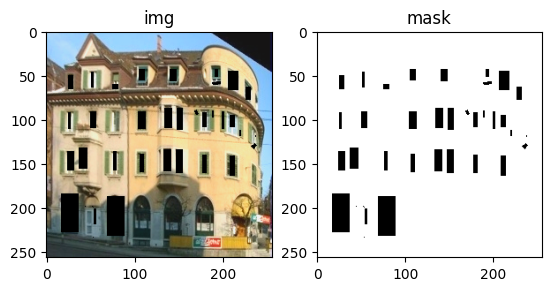

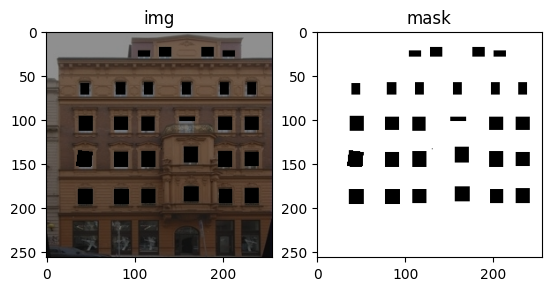

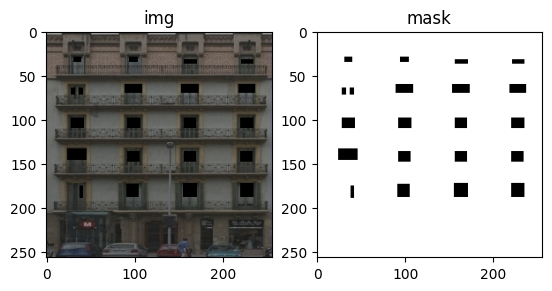

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


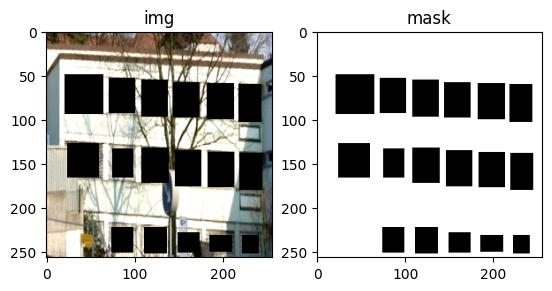

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


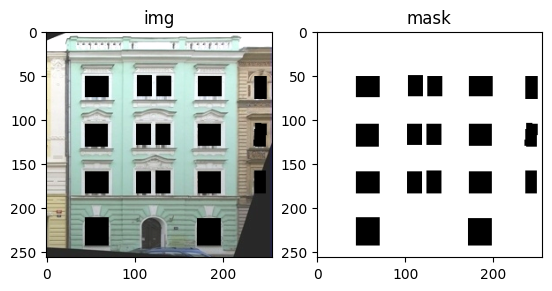

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


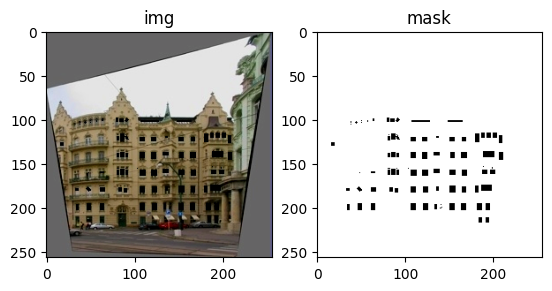

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


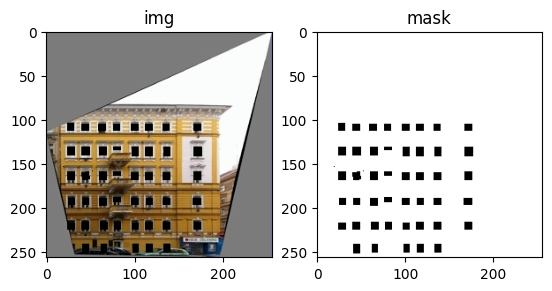

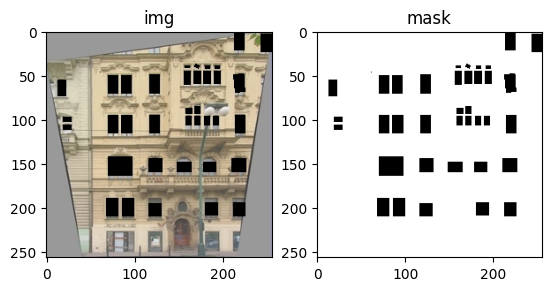

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


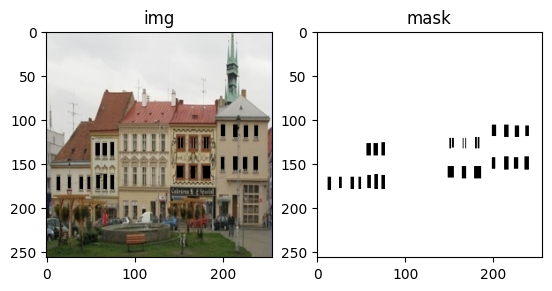

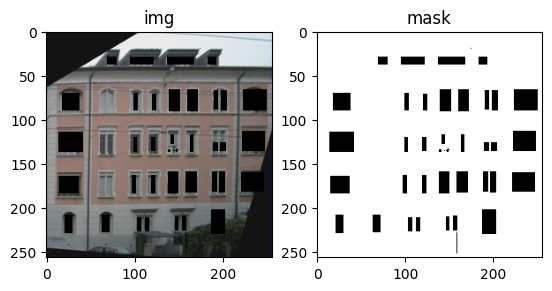

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


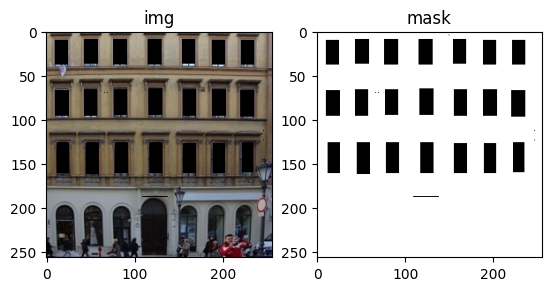

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


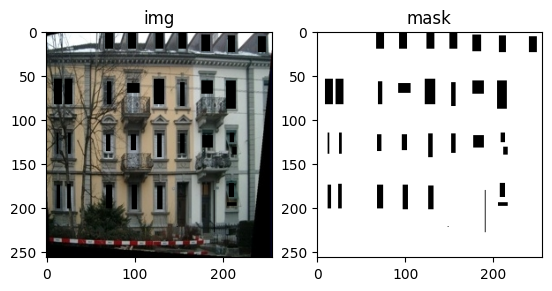

In [11]:
X, y = next(iter(train_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    show_mask(img, mask, mean=mean, std=std)
    
X, y = next(iter(val_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    show_mask(img, mask, mean=mean, std=std)

# Эксперименты

In [25]:
class FCN(nn.Module):
    def __init__(self, in_chanels, activation):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_chanels, 64, 3, padding=1), # 256 X 256
            nn.BatchNorm2d(64),
            activation,
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            # activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 128 X 128
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            # activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 X 64
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            # activation,
            nn.MaxPool2d(kernel_size=2, stride=2) # 32 X 32
         )
        self.conv = nn.Conv2d(256, 1, 1)
        self.up = nn.Upsample(scale_factor=8) # 256 X 256 
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.conv(x)
        x = self.up(x)
        return x
        

In [26]:
def rect_out(preds):
    p = preds.cpu().detach()
    p = (p > 0.5).numpy().astype("uint8")
    for i, img in enumerate(p):
        contours, _ = cv2.findContours(img, \
                                       cv2.RETR_EXTERNAL, \
                                       cv2.CHAIN_APPROX_SIMPLE)
        for con in contours:
            box = cv2.minAreaRect(con)
            box = np.intp(cv2.boxPoints(box))
            cv2.drawContours(img, [box], 0, (255,255,255), -1)
        p[i] = img
    return p

In [27]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, labels, smooth=1):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        labels = labels.view(-1)
        intersection = (preds * labels).sum()
        dice = ((2.0*intersection + smooth)/\
                    (preds.sum() + labels.sum() + smooth))
        return 1 - dice


In [28]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN(3, nn.LeakyReLU(inplace=True)).to(device)
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)

In [29]:
def train(model, criterion, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        for mode in ("train", "val"):
            if mode == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            epoch_loss = 0
            for i, (X, y) in enumerate(loader):
                X = X.to(device)
                y = y.to(device)

                if mode == "train":
                    optimizer.zero_grad()
                    preds = model(X).squeeze(1)
                    loss = criterion(preds, y)
                    loss.backward() 
                    optimizer.step()
                else:
                    with torch.no_grad():
                        preds = model(X).squeeze(1)
                        loss = criterion(preds, y)
                epoch_loss += loss.cpu().item()
            if mode == "train":
                scheduler.step(epoch_loss)
            print(f"{epoch}\t| {mode}\t| loss:\t{epoch_loss / len(loader)}")

In [278]:
train(model, criterion, optim, scheduler, 10)

0	| train	| loss:	0.7488017454743385
0	| val	| loss:	0.750074428319931
1	| train	| loss:	0.5967290088534355
1	| val	| loss:	0.5483611136674881
2	| train	| loss:	0.4958579748868942
2	| val	| loss:	0.4930816054344177
3	| train	| loss:	0.45949656665325167
3	| val	| loss:	0.45754300653934477
4	| train	| loss:	0.44811154156923294
4	| val	| loss:	0.4404038906097412
5	| train	| loss:	0.42691345810890197
5	| val	| loss:	0.4179511457681656
6	| train	| loss:	0.41922020018100736
6	| val	| loss:	0.4283209890127182
7	| train	| loss:	0.4192283272743225
7	| val	| loss:	0.4211802303791046
8	| train	| loss:	0.4252933979034424
8	| val	| loss:	0.42079743146896365
9	| train	| loss:	0.4057158827781677
9	| val	| loss:	0.4289336234331131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


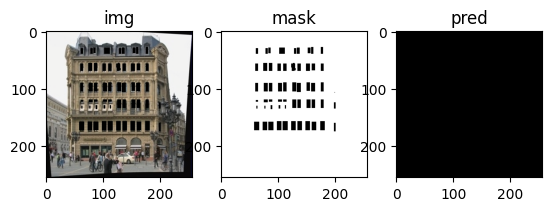

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


acc  0.11568069458007812


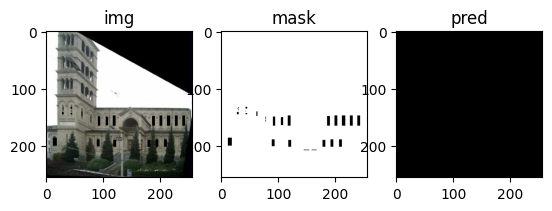

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


acc  0.03418785333633423


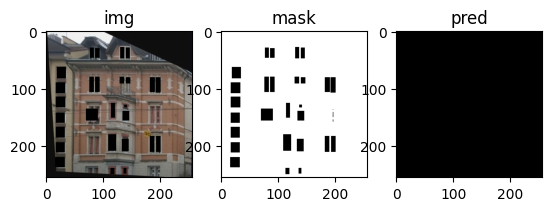

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


acc  0.1529378890991211


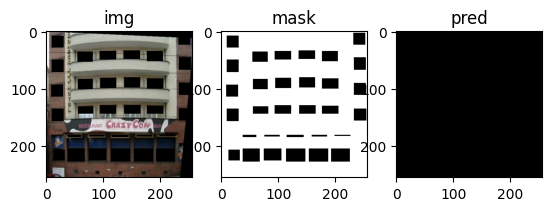

acc  0.29487329721450806


In [19]:
X, y = next(iter(val_loader))
X = X.to(device)
y = y.to(device)

model.eval()
preds = model(X).squeeze(1)
pred = torch.sigmoid(preds).cpu().detach()
# preds = rect_out(preds)
for i in range(len(X)):
    show_mask(X[i].cpu().detach(), y[i].cpu(), pred[i], mean, std)
    print("acc ", 1 - criterion(preds[i].cpu().detach(), y[i].cpu()).item())

In [14]:
class FCNConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    
    def forward(self, x):
        return self.layer(x)

        
class NewFCN(nn.Module):
    def __init__(self, activation=nn.ReLU(inplace=True), upsample_mode="nearest"):
        super().__init__()
        self.inconv = FCNConvBlock(3, 64, activation)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2)
        self.up_list = nn.ModuleList([])
        self.down_list = nn.ModuleList([])
        for i in [64, 128, 256]:
            self.down_list.append(FCNConvBlock(i, i * 2, activation))
        for i in [256, 128, 64, 32]:
            self.up_list.append(FCNConvBlock(i * 2, i, activation))
        self.classifier = nn.Conv2d(32, 1, 1)
        
    def forward(self, x):
        x = self.inconv(x)
        x = self.pool(x)
        for down_layer in self.down_list:
            x = down_layer(x)
            x = self.pool(x)
        for up_layer in self.up_list:
            x = up_layer(x)
            x = self.up(x)
        x = self.classifier(x)
        return x

In [18]:
X = torch.rand(2, 3, 256, 256).float()
y = torch.rand(2, 256, 256).float()
model = NewFCN()
model(X).shape

torch.Size([2, 1, 256, 256])

In [36]:
class UnetConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=None):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    
    def forward(self, x):
        return self.layer(x)



class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation, inblock=None):
        super().__init__()
        self.inconv = nn.Sequential(
            UnetConvBlock(in_channels, out_channels, activation),
            UnetConvBlock(out_channels, out_channels, activation)
        )
        self.pool = nn.MaxPool2d(2, 2)
        
        if inblock:
            self.inblock = inblock
        else:
            self.inblock = nn.Sequential(
                UnetConvBlock(out_channels, out_channels, activation),
                UnetConvBlock(out_channels, out_channels, activation)
            )
        
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.upconv = UnetConvBlock(out_channels, in_channels, activation)
        
        self.outconv = nn.Sequential(
            UnetConvBlock(in_channels + out_channels, in_channels, activation),
            UnetConvBlock(in_channels, in_channels, activation),
        )
    
    
    def forward(self, x):
        inconv = self.inconv(x)
        x = self.pool(inconv)
        
        x = self.inblock(x)
        
        x = self.up(x)
        x = self.upconv(x)
        x = torch.cat((inconv, x), dim=1)
        
        x = self.outconv(x)
        return x
        
        
        
class Unet(nn.Module):
    def __init__(self, channels=64, depth=3, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.inconv = nn.Sequential(
            UnetConvBlock(3, channels, activation),
            UnetConvBlock(channels, channels, activation),
        )
        
        if depth > 10 or depth < 2 or channels % 2 != 0:
            raise ValueError("depth shuld be less than " + \
                             "10 and greater then 1 " +\
                             "and channels should be 2**n")
        n = channels * 2 ** (depth - 1)
        block = UnetBlock(n // 2, n, activation)
        n = n // 2
        while n > channels:
            block = UnetBlock(n // 2, n, activation, block)
            n = n // 2
        self.block = block
        
        self.outconv = nn.Sequential(
            UnetConvBlock(channels, channels, activation),
            nn.Conv2d(channels, 1, 1)
        )
    
    
    def forward(self, x):
        x = self.inconv(x)
        x = self.block(x)
        x = self.outconv(x)
        return x
        

In [65]:
X = torch.rand(1, 3, 256, 256)
model = Unet(channels=64, depth=2)
pred = model(X)
pred.shape

torch.Size([1, 1, 256, 256])

In [40]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels,\
                 out_channels,\
                 down=None,\
                 stride=1,\
                 activation=nn.ReLU()):
        super().__init__()
        self.exp = 2
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, 3, stride, 1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels * self.exp, 1),
            nn.BatchNorm2d(out_channels * self.exp),
        )
        self.down = down
        self.act = activation
    
    def forward(self, x):
        identity = x
        x = self.layer(x)
        
        if self.down is not None:
            identity = self.down(identity)
        x += identity
        x = self.act(x)
        return x


    
class Resnet(nn.Module):
    def __init__(self, channels, layers, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.inconv = nn.Sequential(
            nn.Conv2d(3, 32, 7, 2, 3),
            nn.BatchNorm2d(32),
            activation,
        )
        self.pool = nn.MaxPool2d(3, 2, 1)
    
    
    def make_layer(self, nums, out_channels, stride):
        identity = None
        layers = []
        if stride != 1 or self.channels != out_channels * 2:
            identity = nn

In [37]:
X = torch.rand(1, 256, 256, 256)
# model = ResnetBlock(32, 64, nn.ReLU())
# model(X).shape
model = ResnetBlock(128, 256, )
model(X).shape

torch.Size([1, 256, 256, 256])